In [1]:
# Imports
import torch
import matplotlib.pyplot as plt
import torchvision # torch package for vision related things
import torch.nn.functional as F  # Parameterless functions, like (some) activation functions
import torchvision.datasets as datasets  # Standard datasets
from torch.utils.data import Dataset 
from torch.utils.data import random_split 
import torchvision.transforms as transforms  # Transformations we can perform on our dataset for augmentation
import os
import shutil
import numpy as np
import pandas as pd
from torchvision.io import read_image
from torch import optim  # For optimizers like SGD, Adam, etc.
from torch import nn  # All neural network modules
from torch.utils.data import DataLoader  # Gives easier dataset managment by creating mini batches etc.
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score
from tqdm import tqdm  # For nice progress bar!

from dataGen import Patches
from PIL import Image
import spectral as spec

E:\Software\anaconda3\envs\torch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# AlexNet
class CNN(nn.Module):
    def __init__(self, in_channels=1, num_classes=10):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels= 96, kernel_size= 11, stride=4, padding=0 )
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2)
        self.conv2 = nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride= 1, padding= 2)
        self.conv3 = nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, stride= 1, padding= 1)
        self.conv4 = nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.fc1  = nn.Linear(in_features= 9216, out_features= 4096)
        self.fc2  = nn.Linear(in_features= 4096, out_features= 4096)
        self.fc3 = nn.Linear(in_features=4096 , out_features=num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.maxpool(x)
        x = F.relu(self.conv2(x))
        x = self.maxpool(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = self.maxpool(x)
        x = x.reshape(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [50]:
class ResNet(nn.Module):
    def __init__(self, in_channels=14, num_classes=2):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2, padding=1)
        
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=1)
        
        self.relu = nn.ReLU(inplace=True)
        
        self.downsample = nn.Sequential(
            nn.Conv2d(14, 64, 1, stride=1, bias=False),
            nn.BatchNorm2d(64),
        )
        
        self.fc1 = nn.Linear(1024, 512)
        self.dropout = nn.Dropout(p=0.2)
        self.fc2 = nn.Linear(512, num_classes)
            
    def forward(self, x):
        identity = x
        x = self.conv1(x)  
        x = self.conv2(x)      
        x = self.bn1(x)
        x += self.downsample(identity)
        x = self.relu(x)
        x = self.maxpool(x)         
        
        identity = x
        x = self.conv3(x)  
        x = self.conv4(x)      
        x = self.bn2(x)
        x += identity
        x = self.relu(x)
        x = self.maxpool2(x)
        
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)

        return x

In [22]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [56]:
# Hyperparameters
in_channels = 14
num_classes = 2
img_size = 12
learning_rate = 0.0001
batch_size = 128
num_epochs = 60

In [57]:
# Transformers
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((img_size, img_size)),
    transforms.ConvertImageDtype(torch.float)])
img_transform

Compose(
    ToTensor()
    Resize(size=(12, 12), interpolation=bilinear)
    ConvertImageDtype()
)

In [58]:
patch = Patches()
patch.describe()

background    25956
leaf          16224
diseased        490
Name: class, dtype: int64

In [59]:
patch_dataset = patch.generateDataset(
    dataset_composition = [
        ['diseased',    490],
        ['leaf',        1300],
        ['background',  1300]],
    data_type = 'hdr')

patch_dataset.loc[(patch_dataset['class'] == 'background'), 'class'] = 0
patch_dataset.loc[(patch_dataset['class'] == 'leaf'), 'class'] = 0
patch_dataset.loc[(patch_dataset['class'] == 'diseased'), 'class'] = 1

patch_dataset.describe()

,path,type,class
count,3090,3090,3090
unique,2645,1,2
top,D:\gyeongsang_22_10_28\PATCHES\MOS_CAL_GEOREF_...,hdr,0
freq,7,3090,2600


In [60]:
# Custom Image Dataset
class Img(Dataset):
    def __init__(self, img_df, transform=None, s=100):
        self.img_df = img_df
        self.transform = transform

    def __len__(self):
        return len(self.img_df)

    def __getitem__(self, idx):
        img_path = self.img_df['path'].iloc[idx]
        img = spec.envi.open(img_path)
        np_img = np.array(img[:, :, [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70]])
        label = self.img_df['class'].iloc[idx]
        if self.transform:
            image = self.transform(np_img)
        return image, label

In [61]:
dataset = Img(img_df=patch_dataset, transform=img_transform)

In [62]:
# Load Data
train_dataset, test_dataset = random_split(dataset, [2163, 927])
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

In [63]:
next(iter(train_loader))[0].shape   

torch.Size([128, 14, 12, 12])

In [64]:
def tensorToImg(tensor):
    img = torch.zeros(img_size, img_size, 1)
    for c_y, y in enumerate(tensor[0]):
        for c_x, x in enumerate(y):
            img[c_y][c_x] = x
    return img

In [65]:
def displayImgs(imgs, labels, save=False):
    fig = plt.figure(figsize=(20,11))
    for pos, i in enumerate(imgs[:8]):
        img = tensorToImg(i)
        label = "downy mildew"
        if labels[pos] == 0:
            label = "Non-disease"
        fig.add_subplot(4, 8, pos + 1).title.set_text(label)
        plt.imshow(img)
    plt.subplots_adjust(wspace=0.2)
    plt.show()
    if save:
        fig.savefig('fig.png')

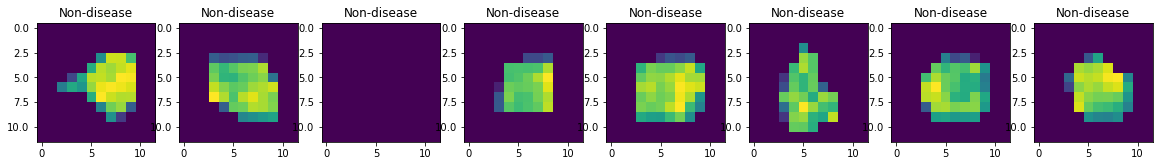

In [66]:
for train_sample in train_loader:
    displayImgs(train_sample[0], train_sample[1], save=True)
    break

In [67]:
# Initialize network
model = ResNet(in_channels=in_channels, num_classes=num_classes).to(device)

In [68]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [69]:
with torch.no_grad():
    for x, y in train_loader:
        x = x.to(device=device)
        y = y.to(device=device)
        x_ = model(x)
        print(x_[0])
        break

tensor([0.8214, 0.6642], device='cuda:0')


In [70]:
# Check accuracy on training & test to see how good our model
def evaluate(loader, model):
    ev = np.zeros(5)
    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)

            scores = model(x)
            _, predictions = scores.max(1)
                        
            y = y.cpu()
            predictions = predictions.cpu()
                        
            ev[0] += 1
            ev[1] += precision_score(y, predictions)
            ev[2] += recall_score(y, predictions)
            ev[3] += f1_score(y, predictions)
            ev[4] += accuracy_score(y, predictions)
            
        ev = ev/ev[0]
        
    model.train()
    return ev*100

In [55]:
print(f"Accuracy on training set: {evaluate(train_loader, model)}")
print(f"Accuracy on test set: {evaluate(test_loader, model)}")

E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: Un

Accuracy on training set: [100.           9.55882353   2.21988796   3.5200747   83.45346362]


E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: Un

Accuracy on test set: [100.           6.89655172   1.07279693   1.83908046  84.14905451]


E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [71]:
history_test = [[] for l in range(6)]
history_train = [[] for l in range(6)]

In [72]:
# Train Network
for epoch in range(num_epochs):
    batch_loss = np.array([])
    loop = tqdm(enumerate(train_loader), total=len(train_loader))
    for batch_idx, (data, targets) in loop:
        # Get data to cuda if possible
        data = data.to(device=device)
        targets = targets.to(device=device)

        # forward
        scores = model(data)
        loss = criterion(scores, targets)

        # backward
        optimizer.zero_grad()
        loss.backward()

        # gradient descent or adam step
        optimizer.step()
        predictions = torch.argmax(scores, dim=1)
               
        #update progess bar
        loop.set_description(f"Epoch[{epoch}/{num_epochs - 1}]")
        
        batch_loss = np.append(batch_loss, loss.item())
    
    history_train[5].append(np.average(batch_loss))
    evaluation_test = evaluate(test_loader, model)
    evaluation_train = evaluate(train_loader, model)
    for i in range(5):
        history_test[i].append(evaluation_test[i])
        history_train[i].append(evaluation_train[i])
        
    print(f"loss: {history_train[5][-1]}\n precision: {history_test[1][-1]}\n recall: {history_test[2][-1]}\n f1 score: {history_test[3][-1]}\n accuracy: {history_test[4][-1]}")

Epoch[0/59]: 100%|█████████████████████████████████████████████████████████████████████| 17/17 [00:17<00:00,  1.03s/it]
E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

loss: 0.4540220989900477
 precision: 0.0
 recall: 0.0
 f1 score: 0.0
 accuracy: 79.92691532258065


Epoch[1/59]: 100%|█████████████████████████████████████████████████████████████████████| 17/17 [00:03<00:00,  4.51it/s]
E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

loss: 0.37183090693810406
 precision: 0.0
 recall: 0.0
 f1 score: 0.0
 accuracy: 82.06590221774194


Epoch[2/59]: 100%|█████████████████████████████████████████████████████████████████████| 17/17 [00:03<00:00,  4.38it/s]
E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

loss: 0.3368123471736908
 precision: 0.0
 recall: 0.0
 f1 score: 0.0
 accuracy: 82.37147177419355


Epoch[3/59]: 100%|█████████████████████████████████████████████████████████████████████| 17/17 [00:03<00:00,  4.61it/s]
E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

loss: 0.33893708621754365
 precision: 0.0
 recall: 0.0
 f1 score: 0.0
 accuracy: 82.67704133064517


Epoch[4/59]: 100%|█████████████████████████████████████████████████████████████████████| 17/17 [00:03<00:00,  4.52it/s]
E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

loss: 0.3208511690883076
 precision: 43.75
 recall: 1.9953796203796206
 f1 score: 3.807754242536851
 accuracy: 82.05330141129032


Epoch[5/59]: 100%|█████████████████████████████████████████████████████████████████████| 17/17 [00:03<00:00,  4.68it/s]


loss: 0.30757436682196226
 precision: 61.030219780219774
 recall: 30.414078674948243
 f1 score: 40.33590627518521
 accuracy: 81.99029737903226


Epoch[6/59]: 100%|█████████████████████████████████████████████████████████████████████| 17/17 [00:03<00:00,  4.62it/s]
E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

loss: 0.29797325502423677
 precision: 43.75
 recall: 2.227941176470588
 f1 score: 4.201076701076702
 accuracy: 81.74773185483872


Epoch[7/59]: 100%|█████████████████████████████████████████████████████████████████████| 17/17 [00:03<00:00,  4.64it/s]


loss: 0.2937851556960274
 precision: 68.4375
 recall: 21.080885713680335
 f1 score: 31.195405713661295
 accuracy: 82.17300907258065


Epoch[8/59]: 100%|█████████████████████████████████████████████████████████████████████| 17/17 [00:03<00:00,  4.56it/s]
E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


loss: 0.2793868113966549
 precision: 73.75
 recall: 9.961831646614254
 f1 score: 17.114033964840413
 accuracy: 83.73865927419355


Epoch[9/59]: 100%|█████████████████████████████████████████████████████████████████████| 17/17 [00:04<00:00,  4.06it/s]
E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

loss: 0.27195490721394033
 precision: 0.0
 recall: 0.0
 f1 score: 0.0
 accuracy: 80.84362399193549


Epoch[10/59]: 100%|████████████████████████████████████████████████████████████████████| 17/17 [00:03<00:00,  4.64it/s]


loss: 0.28408193675910726
 precision: 69.81060606060605
 recall: 41.58831181213903
 f1 score: 52.04618540232673
 accuracy: 85.56892641129032


Epoch[11/59]: 100%|████████████████████████████████████████████████████████████████████| 17/17 [00:03<00:00,  4.64it/s]


loss: 0.25269244698917165
 precision: 67.41310160427807
 recall: 42.038675515183584
 f1 score: 51.54646719571626
 accuracy: 86.09501008064517


Epoch[12/59]: 100%|████████████████████████████████████████████████████████████████████| 17/17 [00:03<00:00,  4.67it/s]
E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


loss: 0.25233810789444866
 precision: 80.20833333333334
 recall: 11.242675088069825
 f1 score: 19.655390107976316
 accuracy: 83.11491935483872


Epoch[13/59]: 100%|████████████████████████████████████████████████████████████████████| 17/17 [00:03<00:00,  4.66it/s]


loss: 0.23267672517720392
 precision: 90.92261904761905
 recall: 21.942555495187072
 f1 score: 34.89389253176018
 accuracy: 85.09324596774194


Epoch[14/59]: 100%|████████████████████████████████████████████████████████████████████| 17/17 [00:03<00:00,  4.57it/s]
E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

loss: 0.2101164013147354
 precision: 62.5
 recall: 9.233700949232986
 f1 score: 15.374338624338623
 accuracy: 82.82195060483872


Epoch[15/59]: 100%|████████████████████████████████████████████████████████████████████| 17/17 [00:03<00:00,  4.51it/s]
E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


loss: 0.21213526848484487
 precision: 72.12752525252525
 recall: 30.089332768680592
 f1 score: 42.39432954760034
 accuracy: 85.84929435483872


Epoch[16/59]: 100%|████████████████████████████████████████████████████████████████████| 17/17 [00:03<00:00,  4.57it/s]


loss: 0.18495545667760513
 precision: 67.0734989648033
 recall: 61.154513888888886
 f1 score: 62.94569299033922
 accuracy: 87.25428427419355


Epoch[17/59]: 100%|████████████████████████████████████████████████████████████████████| 17/17 [00:03<00:00,  4.62it/s]


loss: 0.17654402729342966
 precision: 68.75486744438358
 recall: 68.01229478207166
 f1 score: 67.54806894893102
 accuracy: 88.54901713709677


Epoch[18/59]: 100%|████████████████████████████████████████████████████████████████████| 17/17 [00:03<00:00,  4.62it/s]
E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


loss: 0.17592466228148518
 precision: 87.5
 recall: 8.744393106244438
 f1 score: 15.804338185753517
 accuracy: 82.7116935483871


Epoch[19/59]: 100%|████████████████████████████████████████████████████████████████████| 17/17 [00:03<00:00,  4.64it/s]


loss: 0.17441988780218012
 precision: 84.39685314685315
 recall: 45.439809216489955
 f1 score: 56.83552165013766
 accuracy: 88.14579133064517


Epoch[20/59]: 100%|████████████████████████████████████████████████████████████████████| 17/17 [00:03<00:00,  4.42it/s]


loss: 0.1445649967474096
 precision: 92.2159090909091
 recall: 38.70115629984051
 f1 score: 53.70948075176016
 accuracy: 88.14579133064517


Epoch[21/59]: 100%|████████████████████████████████████████████████████████████████████| 17/17 [00:03<00:00,  4.55it/s]
E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


loss: 0.12705388971987894
 precision: 80.5050505050505
 recall: 29.646915584415588
 f1 score: 43.03372975247975
 accuracy: 87.96307963709677


Epoch[22/59]: 100%|████████████████████████████████████████████████████████████████████| 17/17 [00:03<00:00,  4.51it/s]


loss: 0.14053442548303044
 precision: 50.05080267050172
 recall: 84.83141241879059
 f1 score: 62.60762889630739
 accuracy: 81.45476310483872


Epoch[23/59]: 100%|████████████████████████████████████████████████████████████████████| 17/17 [00:03<00:00,  4.55it/s]


loss: 0.1429291744442547
 precision: 83.11582284515637
 recall: 64.15798120961165
 f1 score: 72.1368374036057
 accuracy: 90.89276713709677


Epoch[24/59]: 100%|████████████████████████████████████████████████████████████████████| 17/17 [00:03<00:00,  4.65it/s]


loss: 0.13438447937369347
 precision: 90.40178571428572
 recall: 28.544233452950557
 f1 score: 41.73345099438455
 accuracy: 86.97391633064517


Epoch[25/59]: 100%|████████████████████████████████████████████████████████████████████| 17/17 [00:03<00:00,  4.57it/s]


loss: 0.10752214228405672
 precision: 97.91666666666667
 recall: 26.25010058344953
 f1 score: 40.94453623979303
 accuracy: 86.87626008064517


Epoch[26/59]: 100%|████████████████████████████████████████████████████████████████████| 17/17 [00:03<00:00,  4.43it/s]


loss: 0.09089056139483172
 precision: 73.85445588893865
 recall: 75.19161092530658
 f1 score: 73.66423493227869
 accuracy: 90.31943044354838


Epoch[27/59]: 100%|████████████████████████████████████████████████████████████████████| 17/17 [00:03<00:00,  4.53it/s]


loss: 0.07464691711699262
 precision: 89.08002235982113
 recall: 59.687177286862635
 f1 score: 71.21836988718725
 accuracy: 90.46433971774194


Epoch[28/59]: 100%|████████████████████████████████████████████████████████████████████| 17/17 [00:03<00:00,  4.41it/s]


loss: 0.07329064410398989
 precision: 78.8646480331263
 recall: 70.80092461885941
 f1 score: 74.27948585923818
 accuracy: 91.16053427419355


Epoch[29/59]: 100%|████████████████████████████████████████████████████████████████████| 17/17 [00:03<00:00,  4.57it/s]


loss: 0.05693773706169689
 precision: 83.07204096213384
 recall: 69.86408669832583
 f1 score: 75.2599045691151
 accuracy: 91.13533266129032


Epoch[30/59]: 100%|████████████████████████████████████████████████████████████████████| 17/17 [00:03<00:00,  4.59it/s]
E:\Software\anaconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


loss: 0.055014402441242165
 precision: 72.95666139416139
 recall: 60.96505468215994
 f1 score: 65.99039681061473
 accuracy: 92.27255544354838


Epoch[31/59]: 100%|████████████████████████████████████████████████████████████████████| 17/17 [00:04<00:00,  3.67it/s]


loss: 0.04941807227099643
 precision: 72.68719211822659
 recall: 79.10365990321654
 f1 score: 75.39415094030146
 accuracy: 91.07547883064517


Epoch[32/59]: 100%|████████████████████████████████████████████████████████████████████| 17/17 [00:04<00:00,  3.62it/s]


loss: 0.04910388621775543
 precision: 54.098636458392555
 recall: 82.51488095238095
 f1 score: 64.98578289526566
 accuracy: 84.60496471774194


Epoch[33/59]: 100%|████████████████████████████████████████████████████████████████████| 17/17 [00:03<00:00,  4.27it/s]


loss: 0.07572628470028148
 precision: 73.29905192983735
 recall: 80.16272088072127
 f1 score: 76.32836589231938
 accuracy: 90.88016633064517


Epoch[34/59]: 100%|████████████████████████████████████████████████████████████████████| 17/17 [00:03<00:00,  4.42it/s]


loss: 0.05452863784397349
 precision: 68.86873543123542
 recall: 78.61607142857143
 f1 score: 72.72015121325649
 accuracy: 88.79158266129032


Epoch[35/59]: 100%|████████████████████████████████████████████████████████████████████| 17/17 [00:03<00:00,  4.48it/s]


loss: 0.04626781679689884
 precision: 79.46267511728038
 recall: 75.55006587615281
 f1 score: 77.12227196442979
 accuracy: 92.05204133064517


Epoch[36/59]: 100%|████████████████████████████████████████████████████████████████████| 17/17 [00:03<00:00,  4.48it/s]


loss: 0.028966912944965503
 precision: 83.67006257631256
 recall: 77.1573833086991
 f1 score: 79.55391083299776
 accuracy: 92.73563508064517


Epoch[37/59]: 100%|████████████████████████████████████████████████████████████████████| 17/17 [00:03<00:00,  4.59it/s]


loss: 0.028095823329161194
 precision: 83.34160982206646
 recall: 76.82328273662212
 f1 score: 79.78142985923306
 accuracy: 93.15146169354838


Epoch[38/59]: 100%|████████████████████████████████████████████████████████████████████| 17/17 [00:04<00:00,  3.98it/s]


loss: 0.023025236969046733
 precision: 76.14327254951021
 recall: 77.65278454376919
 f1 score: 76.3984063969762
 accuracy: 91.66141633064517


Epoch[39/59]: 100%|████████████████████████████████████████████████████████████████████| 17/17 [00:04<00:00,  4.24it/s]


loss: 0.022913638118873623
 precision: 93.90364498202027
 recall: 71.53865566694513
 f1 score: 80.80073527122263
 accuracy: 93.71219758064517


Epoch[40/59]: 100%|████████████████████████████████████████████████████████████████████| 17/17 [00:03<00:00,  4.26it/s]


loss: 0.025269636993899065
 precision: 92.68516385048643
 recall: 78.44550616689364
 f1 score: 84.5130582137161
 accuracy: 95.01953125


Epoch[41/59]: 100%|████████████████████████████████████████████████████████████████████| 17/17 [00:03<00:00,  4.37it/s]


loss: 0.021961721317733034
 precision: 72.10421522921524
 recall: 79.57366727475423
 f1 score: 75.19153246647721
 accuracy: 90.41708669354838


Epoch[42/59]: 100%|████████████████████████████████████████████████████████████████████| 17/17 [00:03<00:00,  4.39it/s]


loss: 0.01840146483086488
 precision: 87.42555271096292
 recall: 78.16768639205117
 f1 score: 82.41249896737702
 accuracy: 93.93271169354838


Epoch[43/59]: 100%|████████████████████████████████████████████████████████████████████| 17/17 [00:04<00:00,  4.14it/s]


loss: 0.013175763956764164
 precision: 91.91337719298245
 recall: 80.83904521404521
 f1 score: 85.58532910053525
 accuracy: 95.01953125


Epoch[44/59]: 100%|████████████████████████████████████████████████████████████████████| 17/17 [00:03<00:00,  4.26it/s]


loss: 0.01378881627255503
 precision: 67.95984028742649
 recall: 82.41493918794677
 f1 score: 73.93564135293427
 accuracy: 89.90360383064517


Epoch[45/59]: 100%|████████████████████████████████████████████████████████████████████| 17/17 [00:03<00:00,  4.62it/s]


loss: 0.01395757740144344
 precision: 81.82416235725059
 recall: 78.67125739184563
 f1 score: 80.11689875032772
 accuracy: 92.63797883064517


Epoch[46/59]: 100%|████████████████████████████████████████████████████████████████████| 17/17 [00:03<00:00,  4.64it/s]


loss: 0.009050682789700873
 precision: 73.98678989139515
 recall: 78.02617423781106
 f1 score: 75.67594323149986
 accuracy: 90.85496471774194


Epoch[47/59]: 100%|████████████████████████████████████████████████████████████████████| 17/17 [00:03<00:00,  4.65it/s]


loss: 0.009256036623435862
 precision: 76.3266568375264
 recall: 79.38572702399428
 f1 score: 77.51838573115332
 accuracy: 91.25819052419355


Epoch[48/59]: 100%|████████████████████████████████████████████████████████████████████| 17/17 [00:03<00:00,  4.63it/s]


loss: 0.007677256157073905
 precision: 86.57288891663892
 recall: 77.68349446689965
 f1 score: 81.52063450562027
 accuracy: 93.62714213709677


Epoch[49/59]: 100%|████████████████████████████████████████████████████████████████████| 17/17 [00:03<00:00,  4.29it/s]


loss: 0.007155918543610503
 precision: 79.18819284631364
 recall: 77.17923543475327
 f1 score: 77.59433969825305
 accuracy: 92.46786794354838


Epoch[50/59]: 100%|████████████████████████████████████████████████████████████████████| 17/17 [00:03<00:00,  4.64it/s]


loss: 0.006705675000215278
 precision: 83.08337646652863
 recall: 77.34428916494134
 f1 score: 78.90832498370419
 accuracy: 92.23475302419355


Epoch[51/59]: 100%|████████████████████████████████████████████████████████████████████| 17/17 [00:03<00:00,  4.60it/s]


loss: 0.006165746791178689
 precision: 75.08558534016201
 recall: 78.46585450818698
 f1 score: 76.52798410769464
 accuracy: 91.55115927419355


Epoch[52/59]: 100%|████████████████████████████████████████████████████████████████████| 17/17 [00:03<00:00,  4.62it/s]


loss: 0.005414945867789143
 precision: 86.21323529411765
 recall: 79.66870713802761
 f1 score: 82.63007539752391
 accuracy: 94.23828125


Epoch[53/59]: 100%|████████████████████████████████████████████████████████████████████| 17/17 [00:03<00:00,  4.45it/s]


loss: 0.005700240651255145
 precision: 79.1224536333232
 recall: 77.86056568489948
 f1 score: 78.09805064519573
 accuracy: 92.84589213709677


Epoch[54/59]: 100%|████████████████████████████████████████████████████████████████████| 17/17 [00:03<00:00,  4.49it/s]


loss: 0.0057601682869169646
 precision: 86.42775581906017
 recall: 78.66999535946313
 f1 score: 81.85605795980818
 accuracy: 93.73739919354838


Epoch[55/59]: 100%|████████████████████████████████████████████████████████████████████| 17/17 [00:03<00:00,  4.55it/s]


loss: 0.004558853147660985
 precision: 86.56382928665536
 recall: 81.0423715538847
 f1 score: 83.46993927881331
 accuracy: 94.140625


Epoch[56/59]: 100%|████████████████████████████████████████████████████████████████████| 17/17 [00:03<00:00,  4.65it/s]


loss: 0.00569343680570669
 precision: 82.31945903361344
 recall: 77.62791895604396
 f1 score: 79.43190060342116
 accuracy: 92.73563508064517


Epoch[57/59]: 100%|████████████████████████████████████████████████████████████████████| 17/17 [00:03<00:00,  4.65it/s]


loss: 0.004083094282952302
 precision: 83.36730813046603
 recall: 79.43443378561345
 f1 score: 80.5103411278937
 accuracy: 93.01600302419355


Epoch[58/59]: 100%|████████████████████████████████████████████████████████████████████| 17/17 [00:03<00:00,  4.63it/s]


loss: 0.0037052088334937304
 precision: 86.13742236024845
 recall: 79.23076923076923
 f1 score: 82.08730301296467
 accuracy: 93.73739919354838


Epoch[59/59]: 100%|████████████████████████████████████████████████████████████████████| 17/17 [00:03<00:00,  4.64it/s]


loss: 0.0033903202891130656
 precision: 82.81639050604566
 recall: 81.24873368319659
 f1 score: 81.31011570842035
 accuracy: 93.54208669354838


In [73]:
def smooth(y, box_pts):
    y = [y[0] for i in range(box_pts)] + y + [y[-1] for i in range(box_pts)]
    box = np.ones(box_pts) / box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth[box_pts: -box_pts]

In [74]:
# print(f"loss: {history_train[5][-1]}\n precision: {history_test[1][-1]}\n recall: {history_test[2][-1]}\n f1 score: {history_test[3][-1]}\n accuracy: {history_test[4][-1]}")

pd_htrain = pd.DataFrame(history_train)
pd_htrain = pd_htrain.T
pd_htrain.to_csv('history_train.csv')

pd_htest = pd.DataFrame(history_test)
pd_htest = pd_htest.T
pd_htest.to_csv('history_test.csv')  

In [75]:
smooth_f = 50

In [76]:
import copy

In [77]:
smooth_h_test = copy.deepcopy(history_test)
smooth_h_train = copy.deepcopy(history_train)

In [78]:
for i in range(len(smooth_h_train)):
    if len(smooth_h_train[i]) > 0:
        smooth_h_train[i] = smooth(smooth_h_train[i], smooth_f)
    if len(smooth_h_test[i]) > 0:
        smooth_h_test[i] = smooth(smooth_h_test[i], smooth_f)

In [79]:
with open('smooth_h_train.txt', 'w') as fp:
    for item in smooth_h_train:
        fp.write("%s\n" % item)
    print('Done')

Done


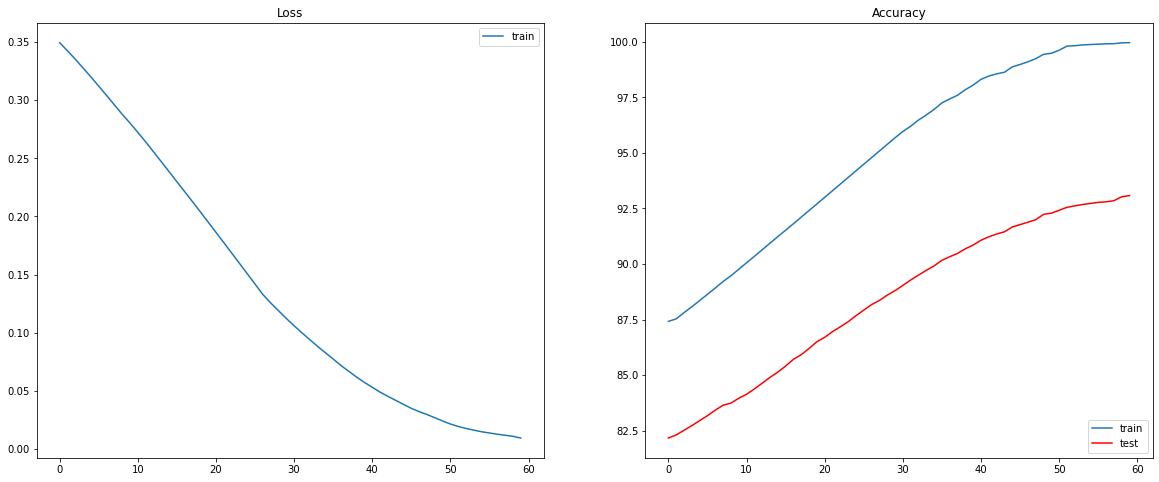

In [80]:
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(20,8))
epochs = [e for e in range(num_epochs)]

ax1.set_title('Loss')
ax2.set_title('Accuracy')

ax1.plot(epochs, smooth_h_train[5], label='train')
ax2.plot(epochs, smooth_h_train[4], label='train')
ax2.plot(epochs, smooth_h_test[4], 'r', label='test')

ax1.legend(loc='upper right')
ax2.legend(loc='lower right')

In [81]:
fig.savefig('training_process.png')

In [82]:
# Predict 
def predict(loader, model, savefig=False):
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)

            scores = model(x)
            _, predictions = scores.max(1)
            displayImgs(x, predictions, savefig)
            break
    model.train()

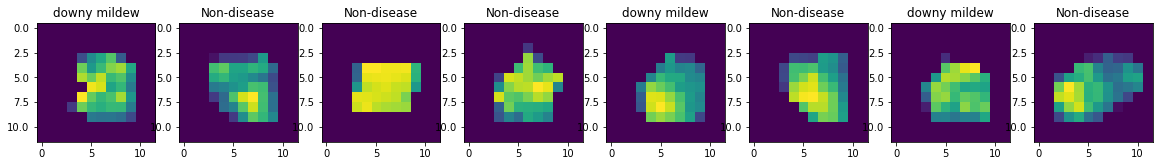

In [83]:
predict(test_loader, model, savefig=True)

In [84]:
torch.save(model.state_dict(), os.getcwd() + "\\downy_mildew_ResNet_HSI.pt")

In [85]:
# Predict 
def predict2(loader, model, savefig=False):
    actual = np.array([])
    prediction = np.array([])
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)

            scores = model(x)
            _, predictions = scores.max(1)
            actual = np.append(actual, y.cpu().detach().numpy())
            prediction = np.append(prediction, predictions.cpu().detach().numpy())
    model.train()
    
    return actual, prediction

In [86]:
actual, prediction = predict2(test_loader, model)

In [ ]:
print(actual)

In [ ]:
print(prediction)

In [87]:
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(actual, prediction)
cmn = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]

In [88]:
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cmn, display_labels = ["non-diseased", "diseased"])

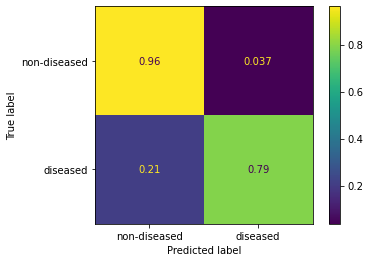

In [89]:
cm_display.plot()
plt.savefig('confusion_matrix.png')
plt.show()